# Vehicle Loan Prediction Machine Learning Model

# 5. Model Evaluation

### Load Libraries and Import Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, recall_score, roc_curve, auc, precision_score

In [2]:
# Suppress warniing to avoid clutter in the output
warnings.filterwarnings("ignore")

In [3]:
# Load the dataset
loan_df = pd.read_csv('../data/vehicle_loans_feat.csv', index_col='UNIQUEID')

Build the simple logistic model

In [4]:
# Specify categorical columns
category_cols = ['MANUFACTURER_ID', 'STATE_ID', 'DISBURSAL_MONTH', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE_DESCRIPTION', 'EMPLOYMENT_TYPE']

# Convert categorical columns to category dtype
loan_df[category_cols] = loan_df[category_cols].astype('category')

In [5]:
# Define columns for the smaller dataset
small_cols = ['STATE_ID', 'LTV', 'DISBURSED_CAT', 'PERFORM_CNS_SCORE', 'DISBURSAL_MONTH', 'LOAN_DEFAULT']
loan_df_sml = loan_df[small_cols]

# Convert categorical variables to dummy variables
loan_data_dumm = pd.get_dummies(loan_df_sml, prefix_sep='_', drop_first=True)

# Seperate features and target variable 
x = loan_data_dumm.drop(['LOAN_DEFAULT'], axis=1)
y = loan_data_dumm['LOAN_DEFAULT']

# Split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Initialise and train the logistic regression model 
logistic_model = LogisticRegression(max_iter=200)
logistic_model.fit(x_train, y_train)

LogisticRegression(max_iter=200)

Now let's use [score](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.score) to get the accuracy of the model

In [6]:
# Get the accuracy of the model
logistic_model.score(x_test, y_test)

0.7822907507881023

## Evaluation Metrics

### Confusion Matrix

- We can create a simple confusion matrix by combining the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) and [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict) functions from sklearn

- First, we need use [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict) to extract our model's predictions on the test data

In [7]:
# Predict classes for the test set
preds = logistic_model.predict(x_test)
preds

array([0, 0, 0, ..., 0, 0, 0])

- We have already seen that [predict](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#sklearn.linear_model.LogisticRegression.predict) returns an array of the predicted classes
- Now we can pass it into the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) method alongside the real classes for our test data

In [8]:
# Create a confusion matrix
conf_mat = confusion_matrix(y_test, preds)
conf_mat

array([[36476,     1],
       [10151,     3]])

Let's extract tn and fp from the confusion matrix

In [9]:
# Extract TN, FP, FN, TP from the confusion matrix
tn = conf_mat[0][0]
fp = conf_mat[0][1]
fn = conf_mat[1][0]
tp = conf_mat[1][1]

Now let's print the outputs

In [10]:
# Print the confusion matrix values
print("True Negatives (Correct Non-Defaults): ", tn)
print("False Positives (Incorrect Defaults): ", fp)
print("False Negatives (Incorrect Non-Defaults): ", fn)
print("True Positives (Correct Defaults)", tp)

True Negatives (Correct Non-Defaults):  36476
False Positives (Incorrect Defaults):  1
False Negatives (Incorrect Non-Defaults):  10151
True Positives (Correct Defaults) 3


Now the 78% accuracy makes a bit more sense, our model is pretty much predicting all loans as non-defaults
 
- Reporting that you predicted 78% correctly might appear impressive, but in reality, the task is to identify loans that will default, from this perspective the model has failed completely 

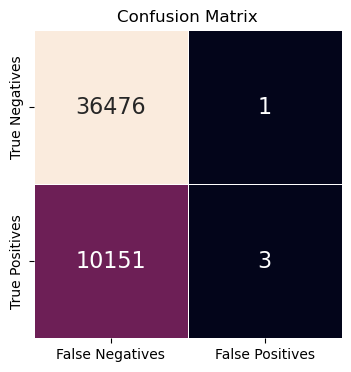

In [11]:
# Create a DataFrame for easier plotting
conf_mat_df = pd.DataFrame(conf_mat, 
                          index=['True Negatives', 'True Positives'],
                          columns=['False Negatives', 'False Positives'])

# Plot confusion matrix
plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat_df, annot=True, fmt='d', 
            linewidths=.5, square=True, cbar=False, 
            annot_kws={"size": 16})
plt.title('Confusion Matrix')
plt.show()

By now you will have gathered that accuracy alone is not a reliable indicator of model performance let's discuss some other measures of performance 

### Precision  = TP/TP + FP 

- Out of those we predicted as positive, how many actually were positive?

In [12]:
# Calculate precision score 
precision = precision_score(y_test, preds)
precision

0.75

Out of the positive predictions, 75% were actually positive. Although, we can see from the confusion matrix that the model  only predicted a small number of instances as positive.

### Recall = TP/TP + FN

- How many of the actual positive cases did we correctly identify?


In [13]:
# Calculate recall score 
recall = recall_score(y_test, preds)
recall

0.00029545006893834944

Recall of ~0.0003, we hardly identified any of the loan defaults

### F1 Score = 2((precision * recall)/(precision + recall))

- Useful when we need a balance between precision and recall
- Less affected by large numbers of true negatives than accuracy 

In [14]:
# Calculate F1 score 
f1 = f1_score(y_test, preds)
f1

0.0005906674542232723

f1 score of ~0.0006 should prove beyond doubt that our model is not reliable despite the 78% accuracy

## Roc Curve

We can dig deeper into the performance of a model by plotting the ROC curve and calculating the AUC

- To plot the ROC curve we first need to extract the predicted probabilities from our model against the test set

In [15]:
# Get predicted probabilities for the test set
probs = logistic_model.predict_proba(x_test)
probs

array([[0.71578339, 0.28421661],
       [0.82148711, 0.17851289],
       [0.79313318, 0.20686682],
       ...,
       [0.77229759, 0.22770241],
       [0.90244303, 0.09755697],
       [0.74428342, 0.25571658]])

We can also create a dataframe and get the summary statistics for our predicted probabilities 

In [16]:
# Create a DataFrame for predicted probabilities
probs_df = pd.DataFrame()
probs_df['prob_0'] = probs[:, 0]
probs_df['prob_1'] = probs[:, 1]

# Summary statistics for predicted probabilities
probs_df.describe()

,prob_0,prob_1
count,46631.000000,46631.000000
mean,0.783689,0.216311
std,0.067801,0.067801
min,0.479748,0.035251
25%,0.740075,0.169014
50%,0.787371,0.212629
75%,0.830986,0.259925
max,0.964749,0.520252


### Plotting the ROC Curve 

- sklearn does not provide an out of the box function for plotting the ROC curve
- but it does provide the [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function which gets us some of the way 

We pass [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) three parameters
- the real labels for the test yet 
- the predicted probability of class 1 for the test set 
- pos_label, the class label of the positive class (1 in our case)


In [17]:
# Plot ROC curve
fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)

The [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html) function returns 3 values

- threshold
- fpr (False Positive Rate)
- tpr (True Positive Rate)

Let's take a look at them

In [18]:
# Print fpr, tpr and threshold
print("FPR: ", fpr)
print("TPR: ", tpr)
print("Threshold: ", threshold)

FPR:  [0.00000000e+00 2.74145352e-05 2.74145352e-05 ... 9.99725855e-01
 9.99725855e-01 1.00000000e+00]
TPR:  [0.00000000e+00 9.84833563e-05 2.95450069e-04 ... 9.99803033e-01
 1.00000000e+00 1.00000000e+00]
Threshold:  [       inf 0.52025218 0.50770693 ... 0.05019614 0.04994988 0.03525106]


Each of these variables is an array of floating-point values, let's put them into a dataframe to try and make sense of them

In [19]:
# Put fpr, tpr and threshold into a DataFrame
roc_df = pd.DataFrame()
roc_df['fpr'] = fpr
roc_df['tpr'] = tpr
roc_df['threshold'] = threshold

# Summary statistics 
roc_df.describe()

,fpr,tpr,threshold
count,16416.000000,16416.000000,1.641600e+04
mean,0.412456,0.523646,inf
std,0.275094,0.287222,NaN
min,0.000000,0.000000,3.525106e-02
25%,0.176111,0.276369,1.858569e-01
50%,0.379691,0.535848,2.277170e-01
75%,0.627896,0.773291,2.715620e-01
max,1.000000,1.000000,inf


- Each variable has 16454 values
- The values of fpr and tpr range from 0 to 1

Essentially, the roc_curve function is evaluating the tpr and fpr for our model using different classification thresholds 

- Each value in threshold represents a different classification threshold

We can use these values to calculate AUC for our model 

The sklearn [auc](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.auc.html) function takes two parameters

- the fpr from [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)
- the tpr from [roc_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html)

In [20]:
# Calculate AUC for our model
roc_auc = auc(fpr, tpr)
print("AUC: ", roc_auc)

AUC:  0.6095903441741269


Our model has an AUC of ~0.61

- The AUC score for a random classifier is 0.5!
- Our model is not doing a good job of separating the classes 

To make life easier we have provided the plot_roc_curve function 

In [21]:
# Function to plot ROC curve
def plot_roc_curve(fpr, tpr, roc_auc):
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

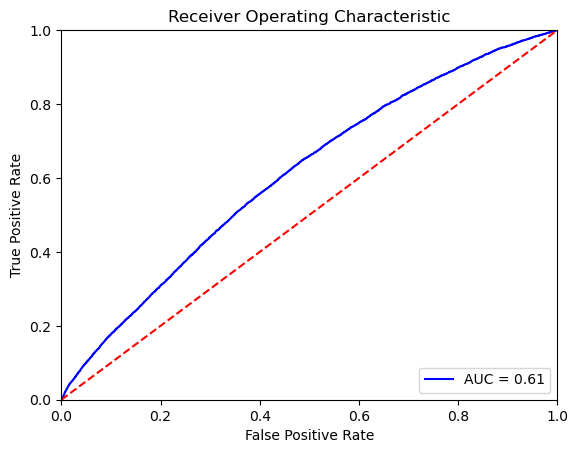

In [22]:
# Plot ROC curve 
plot_roc_curve(fpr, tpr, roc_auc)

## Advanced Evaluation

We will dig deeper into our model performance by looking at class percentage splits and probability distributions 

To make life easier we will create a new DataFrame called results_df with three columns 
- true_class: the true class labels for our test set 
- predicted_class: the predicted class labels for our test set 
- default_prob: the predicted probability of default for the test set

In [23]:
# Create a DataFrame for advanced evaluation
results_df = pd.DataFrame()
results_df['true_class'] = y_test
results_df['predicted_class'] = list(preds)
results_df['default_prob'] = probs[:, 1]

### Class Prediction Percentages 

We can get more insight into model performance by looking at the class prediction percentages 

In other words 
- What percentage of our 1s were predicted as 1s (TPR)
- What percentage of our 1s were predicted as 0s (FNR)
- What percentage of our 0s were predicted as 0s (TNR)
- What percentage of our 0s were predicted as 1s (FPR)


In [24]:
# Class prediction percentages 
results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True)

true_class  predicted_class
0           0                  0.999973
            1                  0.000027
1           0                  0.999705
            1                  0.000295
Name: proportion, dtype: float64

As we expected, nearly all of our test cases were classified as 0s (non defaulted loans)

### Class Probability Distributions 

- We can use results_df to plot the class probability distributions 

Pandas allows us to filter rows using boolean operations

For example, the code below can be used to get the predicted default probability of all the non-defaulted loans 

In [25]:
# Class probability distributions
default_probs_f = results_df[results_df['true_class'] == 0]['default_prob']
default_probs_t = results_df[results_df['true_class'] == 1]['default_prob']

We can use seaborn [distplot](https://seaborn.pydata.org/generated/seaborn.distplot.html) to plot the distributions of our new variables on one chart

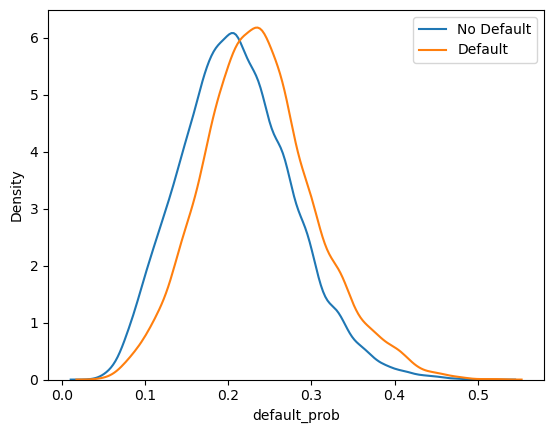

In [26]:
# Plot distributions of predicted probabilities 
sns.distplot(default_probs_f, label="No Default", hist=False)
sns.distplot(default_probs_t, label="Default", hist=False)
plt.legend(loc = 'best')
plt.show()

This chart again shows us that the model has very poor separability

However, we can see that the probability of a defaulted loan being predicted as a default is generally higher than the same probability for a non-default so maybe there is something we can work with

A reusable evaluation function

In [27]:
# def eval_model(model, x_test, y_test):
#     preds = model.predict(x_test)
#     probs = model.predict_proba(x_test)

#     accuracy = accuracy_score(y_test, preds)
#     recall = recall_score(y_test, preds)
#     precision = precision_score(y_test, preds)
#     f1 = f1_score(y_test, preds)

#     plot_confusion_matrix(model, x_test, y_test)
#     plt.show()

#     print("\n")
#     print("Accuracy: ", accuracy)
#     print("Precision: ", precision)
#     print("Recall: ", recall)
#     print("F1: ", f1)

#     #Show ROC Curve 
#     fpr, tpr, threshold = roc_curve(y_test, probs[:,1], pos_label=1)
#     roc_auc = auc(fpr, tpr)
#     print("AUC: ", roc_auc)

#     plot_roc_curve(fpr, tpr, roc_auc)

#     results_df = pd.DataFrame()
#     results_df['true_class'] = y_test
#     results_df['predicted_class'] = list(preds)
#     results_df['default_prob'] = probs[:, 1]

#     #plot the distribution of probabilities for the estimated classes 
#     sns.distplot(results_df[results_df['true_class'] == 0]['default_prob'], label="No Default", hist=False)
#     sns.distplot(results_df[results_df['true_class'] == 1]['default_prob'], label="Default", hist=False)
#     plt.show()
    
#     #see the true class versus predicted class as a percentage
#     print(results_df.groupby('true_class')['predicted_class'].value_counts(normalize=True))

In [28]:
# eval_model(logistic_model, x_test, y_test)